# Overview

This document covers the generation of an event driven analysis of an AIM-format FSAE log using process mining.

## Code Overview

1. Generate events from the log (Ex: Engine RPM high, wide open throttle, max corner).
2. Select an event type of interest and draw a time boundary of +/- seconds around each event occurance.
3. Group all events within each boundary by a common trace ID
4. Perform the process mining
5. Visualize the Performance DF and Markov DF

## Use Cases
- Turn events from a checklist run into DFG graphs.
- Use case 1: (Fault Tree Analysis) Identify how failures cascade across a system (ex: from a minor fault to system failure)
- Use case 2: (Event Tree Analysis) Identify which events are related to each other for system debugging or analysis
- Use case 3: (Test and Verification) Identify if a system can meet a set of performance events, and identify what the deviations are and their behaviors.
- Use Case 4: (Timing analysis) Model the time changes between events, and the 1 sigma deviations to visualize what went through the flow in nominal time, and what traces resulted in longer than nominal.


In [ ]:
# Import required packages and setup environment
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
from IPython.display import display, Image
from examples.example_4.event_extractor import EventExtractor
from examples.example_4.case_generator import CaseGenerator
from examples.example_4.variant_visualization import visualize_chevron_variants

filepath = "./data/raw/FSAE_Endurance_Full.csv"
parsed_filepath = "./data/processed/FSAE_Endurance_Full.csv"

In [14]:
df = pd.read_csv(
    parsed_filepath,
    encoding="latin1",
    low_memory=False,  # Read entire file at once
)

print(df.columns.to_list())

['time.lap_sec', 'distance_km', 'rr.shock_mm', 'rl.shock_mm', 'fl.shock_mm', 'fr.shock_mm', 'acc.lateral_g', 'acc.longitudin_g', 'rear.brake_psi', 'front.brake_psi', 'datalogger.tem_Â°f', 'battery_v', 'f88.rpm_rpm', 'f88.v.speed_mph', 'f88.d.speed_mph', 'f88.speed.fl_mph', 'f88.speed.fr_mph', 'f88.speed.rl_mph', 'f88.speed.rr_mph', 'f88.map1_mbar', 'f88.lambda1_a/f', 'f88.act1_Â°f', 'f88.ect1_Â°f', 'f88.gear_#', 'f88.oil.p1_psi', 'f88.v batt_v', 'f88.fuel.pr1_psi', 'f88.fuel.t_Â°f', 'f88.baro.pr_mbar', 'f88.tps1_%', 'f88.cal.switch_#', 'gps.speed_mph', 'gps.nsat_#', 'gps.latacc_g', 'gps.lonacc_g', 'gps.slope_deg', 'gps.heading_deg', 'gps.gyro_deg/s', 'gps.altitude_m', 'gps.posaccuracy_m', 'fl.shock.pos.zero_mm', 'fr.shock.pos.zero_mm', 'rl.shock.pos.zero_mm', 'rr.shock.pos.zero_mm', 'roll angle_unit', 'fr.roll.gradient_degree', 're.roll.gradient_degree', 'fl.shock.speed_mm/s', 'rr.shock.speed_mm/s', 'rl.shock.speed_mm/s', 'fr.shock.speed_mm/s', 'fl.bumpstop_unit', 'rr.bumpstop_unit', '

# Event conditions

Based on the telemetry columns, here are relevant event conditions for an FSAE team:
1. Lap Events (Fundamental)
Lap Started: lap increments, time.lap_sec resets to ~0
Lap Completed: time.lap_sec reaches max before reset
Sector Crossing: Based on distance_km or aim.distancemeters_m thresholds
2. Driver Performance Events
Braking Events:
Brake Applied: front.brake_psi or rear.brake_psi > threshold (e.g., 50 psi)
Hard Braking: rear.brake_psi > 400 psi AND acc.longitudin_g < -1.0g
Trail Braking: rear.brake_psi decreasing while acc.lateral_g > 0.5g
Brake Released: front.brake_psi < threshold
Cornering Events:
High Lateral Load: acc.lateral_g > 1.2g (aggressive cornering)
Corner Entry: acc.lateral_g increasing + speed decreasing
Corner Apex: acc.lateral_g at local max + gps.gyro_deg/s at max
Corner Exit: acc.lateral_g decreasing + f88.tps1_% increasing
Throttle Events:
Throttle Application: f88.tps1_% > 20%
Full Throttle: f88.tps1_% > 90%
Lift/Coast: f88.tps1_% < 10%
Wheel Spin: f88.d.speed_mph significantly > gps.speed_mph
3. Gear Shift Events
Upshift: f88.gear_# increases
Downshift: f88.gear_# decreases
Shift Under Load: Gear change while f88.tps1_% > 50%
Wrong Gear: f88.rpm_rpm outside optimal range for current gps.speed_mph
4. Suspension/Chassis Events
Bump/Compression:
Bumpstop Hit: fl.bumpstop_unit, fr.bumpstop_unit, etc. = 1 (binary)
Heavy Compression: Shock position (fl.shock_mm, etc.) > 80% travel
Bottoming Event: Max compression rate + bumpstop contact
Roll Event: roll angle_unit or fr.roll.gradient_degree > threshold
Surface Conditions:
Rough Surface: High variance in fl.shock.speed_mm/s or fl.shock.accel_mm/s/s
Jump/Airborne: All shock sensors show rapid extension simultaneously
5. Engine/Powertrain Events
Performance:
Launch: gps.speed_mph 0→moving + f88.tps1_% > 80%
Rev Limiter Hit: f88.rpm_rpm at max sustained value
Overrev: f88.rpm_rpm > safe threshold (e.g., 13,000 rpm)
Lugging: f88.rpm_rpm < 3000 + high load
Fuel System:
Fuel Starvation: f88.lambda1_a/f goes lean (>15) + f88.fuel.pr1_psi drops
Rich Condition: f88.lambda1_a/f < 12.5
High Fuel Flow: fuel flow_cc/min at maximum
6. Temperature Events
Engine Overheating: f88.ect1_°f > 220°F
Oil Overheating: f88.act1_°f > 280°F
Cooling Recovery: Temperature decreasing after peak
7. Pressure/Fluid Events
Low Oil Pressure: f88.oil.p1_psi < 30 psi (critical)
Oil Pressure Spike: run.oil.pres.hi_psi or load.oil.pres.hi_psi exceeds safe limit
Low Fuel Pressure: f88.fuel.pr1_psi < threshold
8. Electrical Events
Low Battery Voltage: battery_v or f88.v batt_v < 12.0V
Voltage Spike: battery_v > 15.0V
GPS Lock Lost: gps.nsat_# < 4
GPS Lock Acquired: gps.nsat_# >= 4
9. Calibration/Mode Events
Calibration Switch Change: f88.cal.switch_# changes value (e.g., rain mode, aggressive mode)
Map Change: f88.map1_mbar threshold changes suggest different tuning
10. Failure/Warning Events
Wheel Lockup: Individual wheel speed (f88.speed.fl_mph, etc.) drops to 0 while others moving
Loss of Traction: Rear wheel speeds >> front wheel speeds
Sensor Anomaly: Any sensor reading NaN, out of physical bounds
Data Logging Issue: cycle time_ms spikes (data acquisition lag)
11. Track Position Events
Straight Section: Low acc.lateral_g + high gps.speed_mph
Technical Section: High frequency f88.gear_# changes
Elevation Change: gps.slope_deg > threshold or gps.elevation_cm changing rapidly
12. Comparative/Session Events
Fastest Sector: Compare time.lap_sec at sector markers across laps
Consistency Check: Lap time variance
Setup Change: Between-run comparisons (different sessions in time.session_sec)


# Extract Events

Now we'll extract various types of events from the telemetry data using the EventExtractor class.

In [15]:
"""Extract all event types from telemetry data."""

# Initialize the event extractor
extractor = EventExtractor(df)

print(f"Event extractor initialized with {len(df)} telemetry rows")
print(
    f"Time range: {df['time.session_sec'].min():.2f}s to {df['time.session_sec'].max():.2f}s"
)
print(f"Number of laps: {df['lap'].max()}")

all_events = []

# # 1. LAP EVENTS
# print("Extracting lap events...")
# lap_events = extractor.detect_state_change_events(
#     column='lap',
#     event_name_prefix='Lap'
# )
# all_events.append(lap_events)
# print(f"  Found {len(lap_events)} lap transitions")

# # 2. GEAR SHIFT EVENTS
# print("Extracting gear shift events...")
# gear_events = extractor.detect_state_change_events(
#     column='f88.gear_#',
#     event_name_prefix='Gear Shift'
# )
# all_events.append(gear_events)
# print(f"  Found {len(gear_events)} gear shifts")

# 3. BRAKING EVENTS
print("Extracting braking events...")
brake_applied = extractor.detect_threshold_events(
    column="front.brake_psi",
    threshold=50,
    condition=">",
    event_name="Brake Applied",
    min_duration_rows=3,
)
all_events.append(brake_applied)
print(f"  Found {len(brake_applied)} brake applications")

hard_braking = extractor.detect_combined_condition_events(
    conditions=[("rear.brake_psi", ">", 400), ("acc.longitudin_g", "<", -1.0)],
    event_name="Hard Braking",
    mode="all",
)
all_events.append(hard_braking)
print(f"  Found {len(hard_braking)} hard braking events")

# 4. THROTTLE EVENTS
print("Extracting throttle events...")
full_throttle = extractor.detect_threshold_events(
    column="f88.tps1_%",
    threshold=90,
    condition=">",
    event_name="Full Throttle",
    min_duration_rows=5,
)
all_events.append(full_throttle)
print(f"  Found {len(full_throttle)} full throttle events")

# 5. CORNERING EVENTS - Local maxima in lateral acceleration
print("Extracting cornering events...")
corner_events = extractor.detect_local_extrema_events(
    column="acc.lateral_g",
    event_name_max="Corner Apex (Left)",
    event_name_min="Corner Apex (Right)",
    window_size=20,
    prominence=0.3,
)
all_events.append(corner_events)
print(f"  Found {len(corner_events)} corner apex events")

# 6. HIGH LATERAL LOAD EVENTS
print("Extracting high lateral load events...")
high_lateral = extractor.detect_threshold_events(
    column="acc.lateral_g",
    threshold=1.2,
    condition=">",
    event_name="High Lateral Load",
    min_duration_rows=5,
)
all_events.append(high_lateral)
print(f"  Found {len(high_lateral)} high lateral load events")

# 7. BUMPSTOP EVENTS
print("Extracting suspension bumpstop events...")
for corner in ["fl", "fr", "rl", "rr"]:
    bumpstop = extractor.detect_threshold_events(
        column=f"{corner}.bumpstop_unit",
        threshold=0.5,
        condition=">",
        event_name=f"Bumpstop Hit ({corner.upper()})",
        min_duration_rows=1,
    )
    if len(bumpstop) > 0:
        all_events.append(bumpstop)
        print(f"  Found {len(bumpstop)} bumpstop hits on {corner.upper()}")

# 8. ENGINE EVENTS
print("Extracting engine events...")
high_rpm = extractor.detect_threshold_events(
    column="f88.rpm_rpm",
    threshold=11000,
    condition=">",
    event_name="High RPM",
    min_duration_rows=10,
)
all_events.append(high_rpm)
print(f"  Found {len(high_rpm)} high RPM events")

# 9. LOW OIL PRESSURE WARNING
print("Extracting oil pressure events...")
low_oil_pressure = extractor.detect_threshold_events(
    column="f88.oil.p1_psi",
    threshold=30,
    condition="<",
    event_name="Low Oil Pressure Warning",
    min_duration_rows=5,
)
if len(low_oil_pressure) > 0:
    all_events.append(low_oil_pressure)
    print(f"  Found {len(low_oil_pressure)} low oil pressure warnings")

# 10. GPS EVENTS
print("Extracting GPS events...")
gps_lock_lost = extractor.detect_threshold_events(
    column="gps.nsat_#",
    threshold=4,
    condition="<",
    event_name="GPS Lock Lost",
    min_duration_rows=10,
)
if len(gps_lock_lost) > 0:
    all_events.append(gps_lock_lost)
    print(f"  Found {len(gps_lock_lost)} GPS lock lost events")

print(f"\n{'=' * 60}")
print(f"Total event categories: {len(all_events)}")
print(f"Total events extracted: {sum(len(e) for e in all_events)}")

Event extractor initialized with 190587 telemetry rows
Time range: 0.01s to 1905.56s
Number of laps: 22
Extracting braking events...
  Found 373 brake applications
  Found 0 hard braking events
Extracting throttle events...
  Found 63 full throttle events
Extracting cornering events...
  Found 4122 corner apex events
Extracting high lateral load events...
  Found 1377 high lateral load events
Extracting suspension bumpstop events...
  Found 19 bumpstop hits on FL
  Found 19 bumpstop hits on FR
  Found 19 bumpstop hits on RL


/home/garre/development/process-mining-demo/examples/example_4/event_extractor.py:65: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rising_edge = mask & ~mask.shift(1).fillna(False)
/home/garre/development/process-mining-demo/examples/example_4/event_extractor.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  duration_check |= mask.shift(-i).fillna(False)
/home/garre/development/process-mining-demo/examples/example_4/event_extractor.py:167: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a fut

  Found 19 bumpstop hits on RR
Extracting engine events...
  Found 4 high RPM events
Extracting oil pressure events...
  Found 461 low oil pressure warnings
Extracting GPS events...

Total event categories: 11
Total events extracted: 6476


# Combine Events into Event Log

Merge all extracted events into a single event dataframe suitable for process mining.

In [16]:
# Combine all events into a single dataframe
events_df = pd.concat(all_events, ignore_index=True)

# Sort by timestamp
events_df = events_df.sort_values("timestamp").reset_index(drop=True)

event_log_path = "./data/processed/FSAE_Event_Log.csv"
events_df.to_csv(event_log_path, index=False)

/tmp/ipykernel_504086/3157444088.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events_df = pd.concat(all_events, ignore_index=True)


# Time Window Case Generator

Create process mining cases based on time windows around specific events of interest.

This allows you to analyze what happens before and after critical events (e.g., analyze the 5 seconds before and 10 seconds after each hard braking event).

**Key Concept**: Instead of using laps as cases, we create cases centered around specific events with configurable time windows.

# Example 1: Analyze Full Throttle Events

Let's create cases around "Full Throttle" events to see what happens before and after the driver goes full throttle.

In [17]:
# Initialize the case generator
case_gen = CaseGenerator(events_df)

# Generate cases around Full Throttle events
# Look at 3 seconds before and 5 seconds after each full throttle application
throttle_cases = case_gen.generate_cases_time_window(
    trigger_event="Full Throttle",
    time_before=0.0,  # 0 seconds before
    time_after=5.0,  # 5 seconds after
    case_prefix="FullThrottle",
)

print(f"\n{'=' * 60}")
print("First case example:")
first_case = throttle_cases[throttle_cases["case_id"] == "FullThrottle_0001"]
print(
    first_case[["event_sequence", "activity", "time_relative_to_trigger", "is_trigger"]]
)

TimeWindowCaseGenerator initialized with 6476 events
Found 63 trigger event occurrences
Time window: -0.0s to +5.0s around each trigger

Generated 63 cases
Total event-case assignments: 1281
Average events per case: 20.3
Event overlap ratio: 1.00x (events appear in multiple cases)

First case example:
    event_sequence             activity  time_relative_to_trigger  is_trigger
0                1        Full Throttle                      0.00        True
1                2             High RPM                      0.59       False
2                3   Corner Apex (Left)                      1.12       False
3                4   Corner Apex (Left)                      2.89       False
4                5  Corner Apex (Right)                      2.99       False
5                6    High Lateral Load                      3.16       False
6                7    High Lateral Load                      3.21       False
7                8   Corner Apex (Left)                      3.27       F

# Example 2: Analyze Bumpstop Events

Create cases around suspension bumpstop hits to understand what leads to bottoming out.

In [18]:
# Generate cases around any bumpstop hit (all 4 corners)
bumpstop_triggers = [
    "Bumpstop Hit (FL)",
    "Bumpstop Hit (FR)",
    "Bumpstop Hit (RL)",
    "Bumpstop Hit (RR)",
]

bumpstop_cases = case_gen.generate_cases_time_window(
    trigger_event=bumpstop_triggers,
    time_before=5.0,  # 5 seconds before
    time_after=0.0,  # 0 seconds after
    case_prefix="Bumpstop",
)

print(f"\n{'=' * 60}")
print("First case example:")
first_case = bumpstop_cases[bumpstop_cases["case_id"] == "Bumpstop_0001"]
print(
    first_case[["event_sequence", "activity", "time_relative_to_trigger", "is_trigger"]]
)

Found 76 trigger event occurrences
Time window: -5.0s to +0.0s around each trigger

Generated 76 cases
Total event-case assignments: 516
Average events per case: 6.8
Event overlap ratio: 1.00x (events appear in multiple cases)

First case example:
   event_sequence                  activity  time_relative_to_trigger  \
0               1         Bumpstop Hit (FL)                       0.0   
1               2         Bumpstop Hit (FR)                       0.0   
2               3         Bumpstop Hit (RL)                       0.0   
3               4         Bumpstop Hit (RR)                       0.0   
4               5  Low Oil Pressure Warning                       0.0   

   is_trigger  
0        True  
1       False  
2       False  
3       False  
4       False  


# Export Cases for Process Mining

Save the case-based event logs for use with PM4PY or other process mining tools.

In [19]:
# Save all case-based event logs
output_dir = "./data/processed/"

# Full throttle cases
throttle_path = f"{output_dir}cases_full_throttle.csv"
throttle_cases.to_csv(throttle_path, index=False)
print(f"Full Throttle cases saved to: {throttle_path}")

# Bumpstop cases
bumpstop_path = f"{output_dir}cases_bumpstop.csv"
bumpstop_cases.to_csv(bumpstop_path, index=False)
print(f"Bumpstop cases saved to: {bumpstop_path}")

Full Throttle cases saved to: ./data/processed/cases_full_throttle.csv
Bumpstop cases saved to: ./data/processed/cases_bumpstop.csv


# Process Mining Analysis on Throttle Cases

Now we'll use PM4PY to analyze the Full Throttle cases and discover event patterns.

In [20]:
# Format the throttle_cases dataframe for PM4PY
# PM4PY requires specific column names: case_id, activity, timestamp
throttle_df_pm4py = pm4py.format_dataframe(
    throttle_cases,
    case_id="case_id",
    activity_key="activity",
    timestamp_key="timestamp",
)

# Convert to event log
throttle_event_log = pm4py.convert_to_event_log(throttle_df_pm4py)

print(f"PM4PY Event Log Created:")
print(f"  Number of cases: {len(throttle_event_log)}")
print(f"  Number of events: {sum(len(case) for case in throttle_event_log)}")
print(
    f"  Number of unique activities: {len(set(event['concept:name'] for case in throttle_event_log for event in case))}"
)

# Display first few events of first case
print(f"\nFirst case preview:")
first_case = throttle_event_log[0]
for i, event in enumerate(first_case[:10]):
    print(f"  {i + 1}. {event['concept:name']} at {event['time:timestamp']}")

PM4PY Event Log Created:
  Number of cases: 63
  Number of events: 1281
  Number of unique activities: 7

First case preview:
  1. Full Throttle at 2016-05-14 16:28:28.740000+00:00
  2. High RPM at 2016-05-14 16:28:29.330000+00:00
  3. Corner Apex (Left) at 2016-05-14 16:28:29.860000+00:00
  4. Corner Apex (Left) at 2016-05-14 16:28:31.630000+00:00
  5. Corner Apex (Right) at 2016-05-14 16:28:31.730000+00:00
  6. High Lateral Load at 2016-05-14 16:28:31.900000+00:00
  7. High Lateral Load at 2016-05-14 16:28:31.950000+00:00
  8. Corner Apex (Left) at 2016-05-14 16:28:32.010000+00:00
  9. Corner Apex (Right) at 2016-05-14 16:28:32.130000+00:00
  10. Corner Apex (Left) at 2016-05-14 16:28:32.320000+00:00


## Performance DFG (Directly-Follows Graph)

This shows the flow of events with **timing information** - how long it typically takes to go from one event to the next.

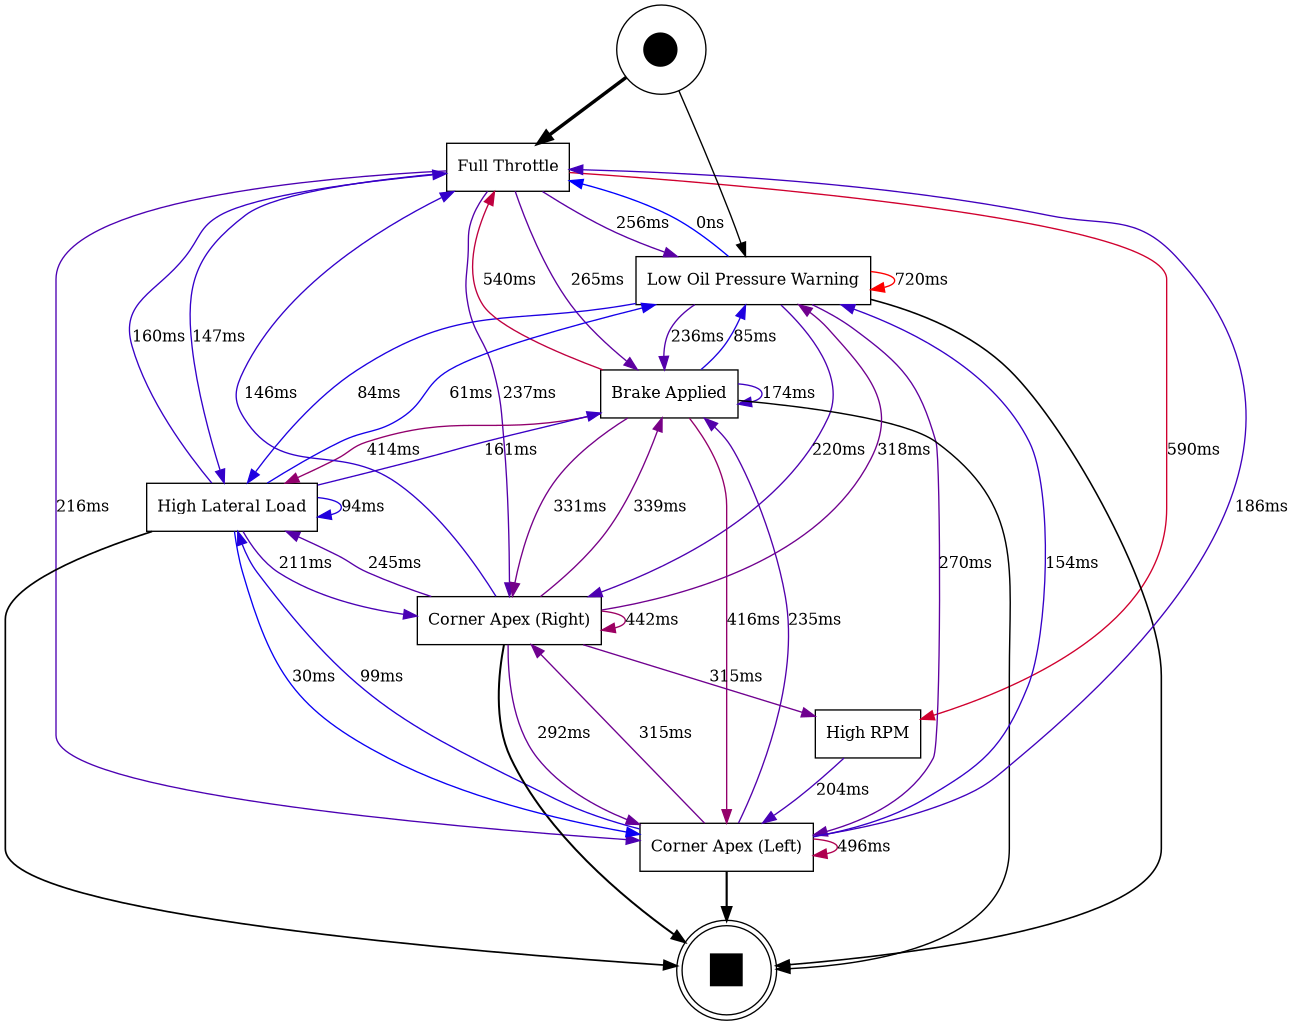

In [21]:
# Discover performance DFG - returns tuple (dfg_dict, start_activities, end_activities)
dfg_perf, sa_perf, ea_perf = pm4py.discover_performance_dfg(throttle_event_log)

# Visualize with performance (time) annotations
perf_filename = "./data/processed/throttle_cases_dfg_performance.png"
pm4py.save_vis_performance_dfg(
    dfg_perf, sa_perf, ea_perf, str(perf_filename), rankdir="TB"
)

display(Image(perf_filename, width=1000))

## Markov Chain DFG (Frequency-based)

This shows the flow of events with **frequency information** - how often each path is taken (like a Markov chain transition probability).

Markov DFG saved to: ./data/processed/throttle_cases_dfg_markov.png


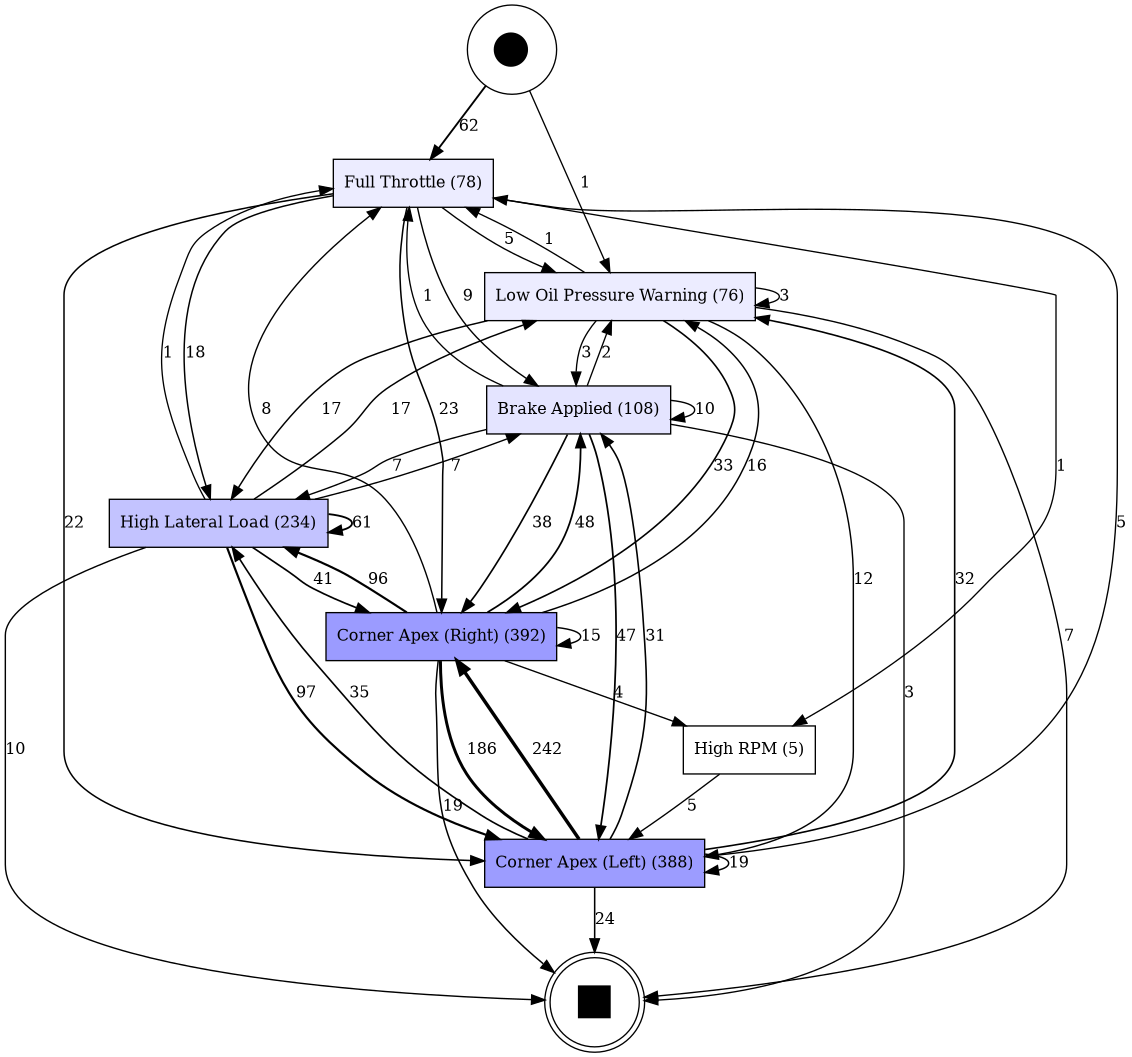

In [22]:
"""Generate a Directly-Follows Graph as a Markov chain, visualizing the variant flows."""

# Discover DFG with frequency annotations
dfg_markov, sa_markov, ea_markov = pm4py.discover_directly_follows_graph(
    throttle_event_log
)

# Visualize with frequency annotations
markov_filename = "./data/processed/throttle_cases_dfg_markov.png"
pm4py.save_vis_dfg(dfg_markov, sa_markov, ea_markov, str(markov_filename), rankdir="TB")
print(f"Markov DFG saved to: {markov_filename}")

display(Image(markov_filename, width=1000))

# Variant Analysis with Chevron Visualization

Discover the different process variants (unique event sequences) and visualize them as chevron-style workflow paths.

In [23]:
"""Extract process variants from throttle cases."""

# Get variants using PM4PY
variants = pm4py.get_variants(
    throttle_event_log,
    activity_key="concept:name",
    case_id_key="case:concept:name",
    timestamp_key="time:timestamp",
)

# Calculate variant statistics
total_cases = len(throttle_event_log)
variant_stats = [
    {
        "Variant": variant,
        "Count": len(cases),
        "Percentage": round((len(cases) / total_cases) * 100, 2),
        "Length": len(variant),
    }
    for variant, cases in variants.items()
]

# Create DataFrame and sort by frequency
variant_stats_df = pd.DataFrame(variant_stats).sort_values("Count", ascending=False)

print(f"Variant Analysis Summary:")
print(f"{'=' * 60}")
print(f"Total unique variants: {len(variant_stats_df)}")
print(
    f"Most common variant occurs: {variant_stats_df.iloc[0]['Count']} times ({variant_stats_df.iloc[0]['Percentage']}%)"
)
print(f"Average variant length: {variant_stats_df['Length'].mean():.1f} events")
print(f"\nTop 10 variants by frequency:")
print(variant_stats_df.head(10)[["Count", "Percentage", "Length"]])

Variant Analysis Summary:
Total unique variants: 63
Most common variant occurs: 1 times (1.59%)
Average variant length: 20.3 events

Top 10 variants by frequency:
    Count  Percentage  Length
0       1        1.59      19
47      1        1.59      16
34      1        1.59      30
35      1        1.59      28
36      1        1.59      25
37      1        1.59      15
38      1        1.59      31
39      1        1.59      15
40      1        1.59      16
41      1        1.59      13


## Chevron Workflow Visualization

Create a chevron/pipeline-style visualization for each variant, showing the sequential flow of events.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Chevron variant visualization saved to: ./data/processed/throttle_variants_chevron.png


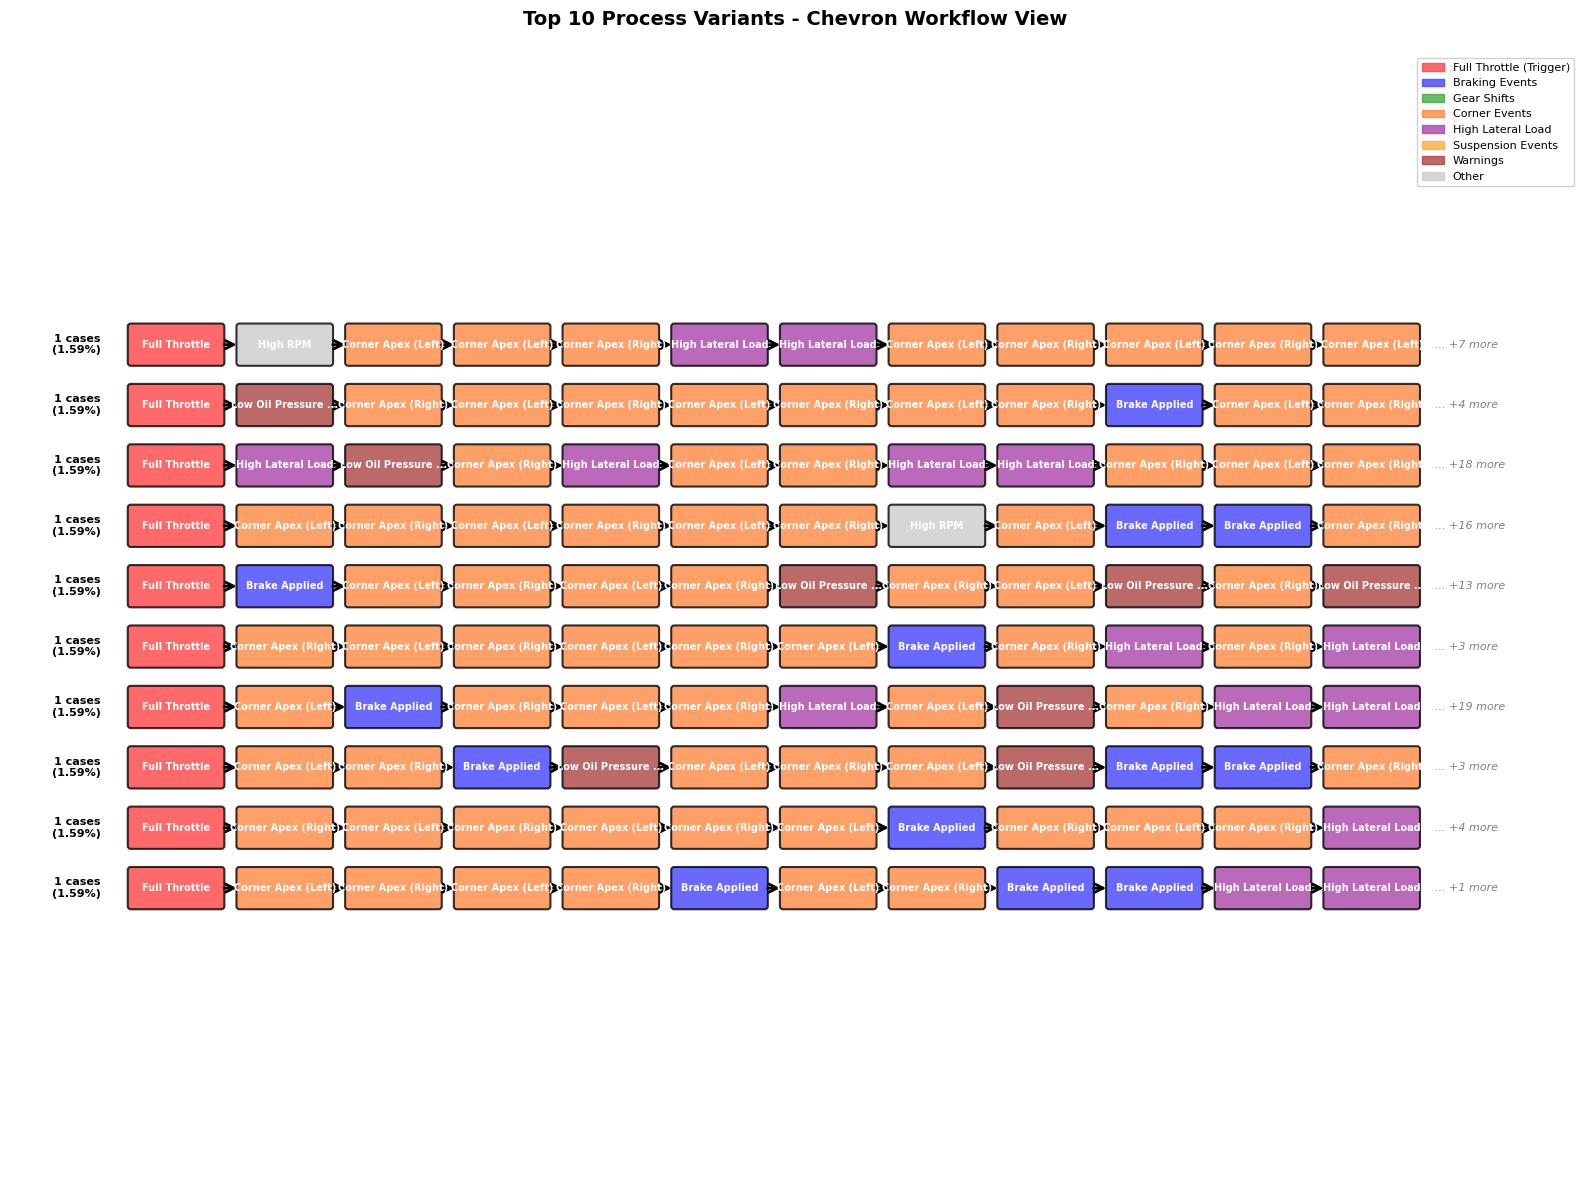

In [ ]:

# Create the visualization
fig = visualize_chevron_variants(
    variant_stats_df, max_variants=10, max_events_per_variant=12
)
chevron_filename = "./data/processed/throttle_variants_chevron.png"
plt.savefig(chevron_filename, dpi=150, bbox_inches="tight", facecolor="white")
print(f"Chevron variant visualization saved to: {chevron_filename}")
plt.show()

## Analyze the bottom out events using process mining

In [25]:
# Format the throttle_cases dataframe for PM4PY
# PM4PY requires specific column names: case_id, activity, timestamp
throttle_df_pm4py = pm4py.format_dataframe(
    bumpstop_cases,
    case_id="case_id",
    activity_key="activity",
    timestamp_key="timestamp",
)

# Convert to event log
bumpstop_event_log = pm4py.convert_to_event_log(throttle_df_pm4py)

print(f"PM4PY Event Log Created:")
print(f"  Number of cases: {len(bumpstop_event_log)}")
print(f"  Number of events: {sum(len(case) for case in bumpstop_event_log)}")
print(
    f"  Number of unique activities: {len(set(event['concept:name'] for case in bumpstop_event_log for event in case))}"
)

# Display first few events of first case
print(f"\nFirst case preview:")
first_case = bumpstop_event_log[0]
for i, event in enumerate(first_case[:10]):
    print(f"  {i + 1}. {event['concept:name']} at {event['time:timestamp']}")

PM4PY Event Log Created:
  Number of cases: 76
  Number of events: 516
  Number of unique activities: 7

First case preview:
  1. Bumpstop Hit (FL) at 2016-05-14 16:27:26.010000+00:00
  2. Bumpstop Hit (FR) at 2016-05-14 16:27:26.010000+00:00
  3. Bumpstop Hit (RL) at 2016-05-14 16:27:26.010000+00:00
  4. Bumpstop Hit (RR) at 2016-05-14 16:27:26.010000+00:00
  5. Low Oil Pressure Warning at 2016-05-14 16:27:26.010000+00:00


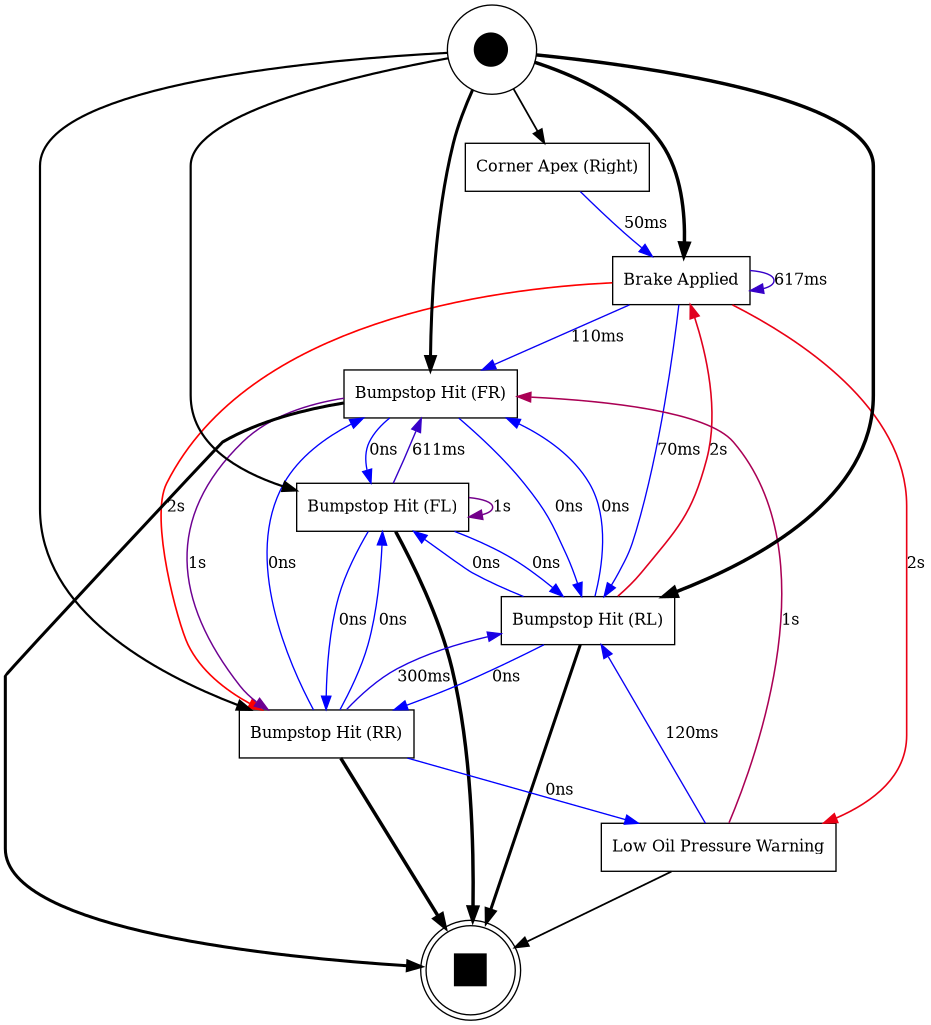

In [26]:
# Discover performance DFG - returns tuple (dfg_dict, start_activities, end_activities)
dfg_perf, sa_perf, ea_perf = pm4py.discover_performance_dfg(bumpstop_event_log)

# Visualize with performance (time) annotations
perf_filename = "./data/processed/bumpstop_cases_dfg_performance.png"
pm4py.save_vis_performance_dfg(
    dfg_perf, sa_perf, ea_perf, str(perf_filename), rankdir="TB"
)

display(Image(perf_filename, width=1000))

Markov DFG saved to: ./data/processed/bumpstop_cases_dfg_markov.png


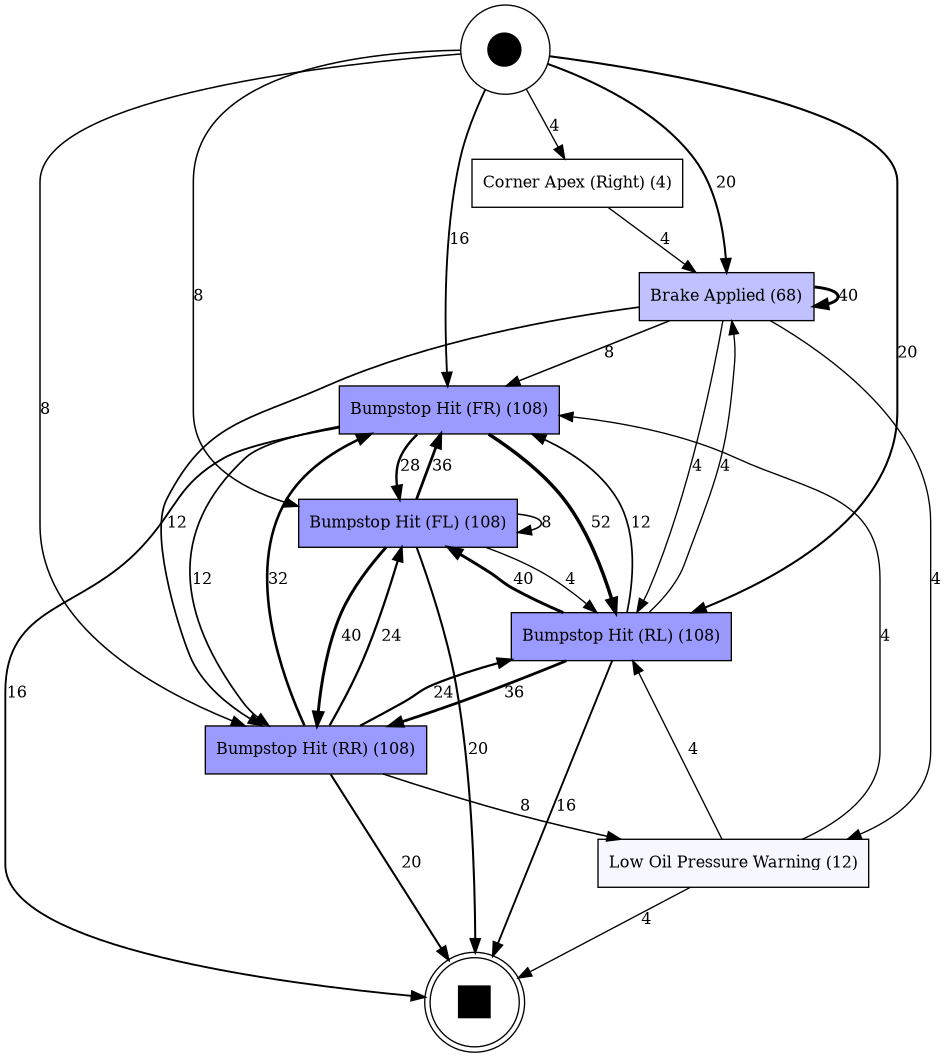

In [27]:
"""Generate a Directly-Follows Graph as a Markov chain, visualizing the variant flows."""

# Discover DFG with frequency annotations
dfg_markov, sa_markov, ea_markov = pm4py.discover_directly_follows_graph(
    bumpstop_event_log
)

# Visualize with frequency annotations
markov_filename = "./data/processed/bumpstop_cases_dfg_markov.png"
pm4py.save_vis_dfg(dfg_markov, sa_markov, ea_markov, str(markov_filename), rankdir="TB")
print(f"Markov DFG saved to: {markov_filename}")

display(Image(markov_filename, width=1000))